In [22]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

# Data Loading
df_gene_mean_bulk= pd.read_csv("~/Desktop/PharmaHacks-2024/csv/gene_mean_bulk.csv")
df_gene_mean_celltype= pd.read_csv("~/Desktop/PharmaHacks-2024/csv/gene_mean_celltype.csv")
df_pathway_mean= pd.read_csv("~/Desktop/PharmaHacks-2024/csv/pathway_mean.csv")
df_proportion_logit= pd.read_csv("~/Desktop/PharmaHacks-2024/csv/proportion_logit.csv")
df_proportion_ratio= pd.read_csv("~/Desktop/PharmaHacks-2024/csv/proportion_ratio.csv")
df_gene_proportion_celltype= pd.read_csv("~/Desktop/PharmaHacks-2024/csv/gene_proportion_celltype.csv")
df_proportion_raw= pd.read_csv("~/Desktop/PharmaHacks-2024/csv/proportion_raw.csv")
df_labels = pd.read_csv("~/Desktop/PharmaHacks-2024/csv/unique_patient_outcomes.csv")
df = pd.read_excel("~/Desktop/PharmaHacks-2024/csv/Genes_-_Platelet_Count_Associated_with_Covid.xlsx")

featureSet = [df_gene_mean_bulk, df_gene_mean_celltype, df_pathway_mean, df_proportion_logit, df_proportion_ratio, df_gene_proportion_celltype, df_proportion_raw]
featureCategoryNames = ["gene_mean_bulk","gene_mean_celltype","pathway_mean", "proportion_logit", "proportion_ratio", "gene_proportion_celltype","proportion_raw"]



In [38]:


column_f_list = df.iloc[:, 5].tolist()
column_f_list = column_f_list[4:]
genes_to_look_for = ["ABO","ACE2","TYK2", "PLEC", "SECISBP2L", "PPP1R15A", "CEACAM8", "MPO", "ELANE", "CD66b", "FUT4"]
for gene in column_f_list:
    genes_to_look_for.append(gene)
common_genes = []

for gene in genes_to_look_for:
            if gene in df_gene_mean_bulk.columns:
                common_genes.append(gene)
                print(f"Gene {gene} found")
df_common_genes = df_gene_mean_bulk.loc[:, common_genes]

# featureSet[0] = df_common_genes



all_predictions = []

for i, features in enumerate(featureSet):
    features = features.drop("Unnamed: 0", axis=1)
    labels = df_labels["Outcome"]
    
    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Initialize and train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    
    # Making predictions
    y_pred = knn.predict(X_test)
    
    # Storing predictions for majority voting later
    all_predictions.append(y_pred)
    
    # Calculating accuracy and cross-validation scores
    print(featureCategoryNames[i], "Accuracy:", accuracy_score(y_test, y_pred))
    scores = cross_val_score(knn, features, labels, cv=13)
    print("Mean cross-validation score:", scores.mean())
    print("---------------------------------")

# Manual Majority Voting
# Initialize a list to hold the final majority vote predictions
majority_votes = []

# Iterate through each prediction set by test sample
for test_sample_index in range(len(y_test)):
    # Collect the predictions for the current test sample across all feature sets
    current_sample_predictions = [predictions[test_sample_index] for predictions in all_predictions]
    
    # Count the frequency of each prediction and select the most common
    prediction_counts = {pred: current_sample_predictions.count(pred) for pred in current_sample_predictions}
    majority_vote = max(prediction_counts, key=prediction_counts.get)
    
    # Add the majority vote prediction to the final list
    majority_votes.append(majority_vote)

print("Majority Voting Accuracy:", accuracy_score(y_test, majority_votes))

Gene PLEC found
Gene SECISBP2L found
Gene PPP1R15A found
Gene CEACAM8 found
Gene MPO found
Gene ELANE found
gene_mean_bulk Accuracy: 0.7
Mean cross-validation score: 0.8333333333333334
---------------------------------
gene_mean_celltype Accuracy: 0.9
Mean cross-validation score: 0.846153846153846
---------------------------------
pathway_mean Accuracy: 0.9
Mean cross-validation score: 0.7884615384615383
---------------------------------
proportion_logit Accuracy: 0.9
Mean cross-validation score: 0.9423076923076923
---------------------------------
proportion_ratio Accuracy: 0.9
Mean cross-validation score: 0.9358974358974359
---------------------------------
gene_proportion_celltype Accuracy: 0.9
Mean cross-validation score: 0.891025641025641
---------------------------------
proportion_raw Accuracy: 0.8
Mean cross-validation score: 0.8717948717948717
---------------------------------
Majority Voting Accuracy: 0.8


Selected features: Index(['ATP5F1E', 'RPS17', 'MTRNR2L12', 'C14orf2', 'ATP5G2', 'TCEB2', 'ATP5L',
       'AC090498.1', 'GNB2L1', 'ATP5E'],
      dtype='object')
Accuracy: 0.9
F1 Score: 0.9044444444444444
CV Average Score: 0.828888888888889


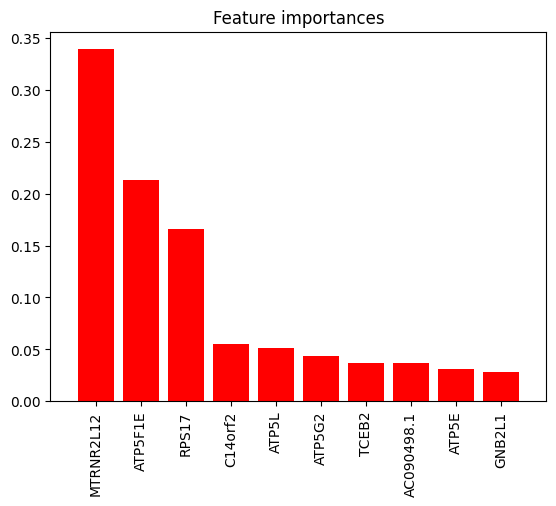

In [33]:

X = df_gene_mean_bulk.drop('Unnamed: 0', axis=1) 
y = df_labels['Outcome']

# Feature Selection
selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(X, y)
# Get the selected feature names
features = selector.get_support(indices=True)
feature_names = X.columns[features]
print("Selected features:", feature_names)

# Model Training and Evaluation
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# Make predictions
y_pred = rf.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  
print("Accuracy:", accuracy)
print("F1 Score:", f1)
# Cross-validation
cv_scores = cross_val_score(rf, X_new, y, cv=5, scoring='accuracy')
print("CV Average Score:", cv_scores.mean())

# Visualization
# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()



In [36]:

df = df_gene_mean_celltype

X = df.drop('Unnamed: 0', axis=1)  # Features
y =  df_labels["Outcome"]

# Scale features (important for chi2)
X_scaled = X


k_values = []
k_results= []
# Select top k features

k = 'all'  
k_values.append(k)
X_new = SelectKBest(chi2, k=k).fit_transform(X_scaled, y)


X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)



# Initializing the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Training the classifier
knn.fit(X_train, y_train)


# Performing 10-fold cross-validation
cv_scores = cross_val_score(knn, X_new, y, cv=13)

# Calculating the mean and standard deviation of the scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
k_results.append(mean_cv_score)
print(f'Mean CV Score: {mean_cv_score*100:.2f}%')
print(f'Standard Deviation of CV Scores: {std_cv_score*100:.2f}%')

print(k_results)
# X_scaled is the scaled version of X, and it's a NumPy array
k = 'all'  

# Fit SelectKBest to the scaled data
selector = SelectKBest(chi2, k=k)
selector.fit(X_scaled, y)

# Get scores for each feature (assuming scaling doesn't alter the order of columns)
scores = selector.scores_

# Create a DataFrame to hold feature scores, using the column names from the original DataFrame
features_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})

# Drop NaN scores if any (can happen if a feature has constant value)
features_scores = features_scores.dropna()

# Rank the features based on their scores
features_scores = features_scores.sort_values(by='Score', ascending=False)

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)
features_scores.head(10)


Mean CV Score: 84.62%
Standard Deviation of CV Scores: 17.56%
[0.846153846153846]


,Feature,Score
15103,6: Immature Neutrophils--LTF,97.567372
15200,6: Immature Neutrophils--S100A8,94.453252
15112,6: Immature Neutrophils--RETN,87.539055
15107,6: Immature Neutrophils--LCN2,86.658265
15098,6: Immature Neutrophils--DEFA3,75.656955
15201,6: Immature Neutrophils--S100A9,71.586954
15426,6: Immature Neutrophils--ATP5F1E,69.198740
15214,6: Immature Neutrophils--S100P,65.769064
15111,6: Immature Neutrophils--MMP8,64.722158
15100,6: Immature Neutrophils--CAMP,61.515777
